# Proyecto final
_Juliana Vallejo, Paola Fernández, María Camila Vásquez_

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

**Lectura de datos**

In [2]:
X = pd.read_csv('datos.csv')['BABA']
X = X.reindex(index=X.index[::-1])
X = np.array(X)
N = len(X)
R = np.zeros(N)
# Retornos instantáneos
for j in range(1,N):
        R[j-1] = (X[j] - X[j-1])/X[j-1]

**Gráfica de la acción**

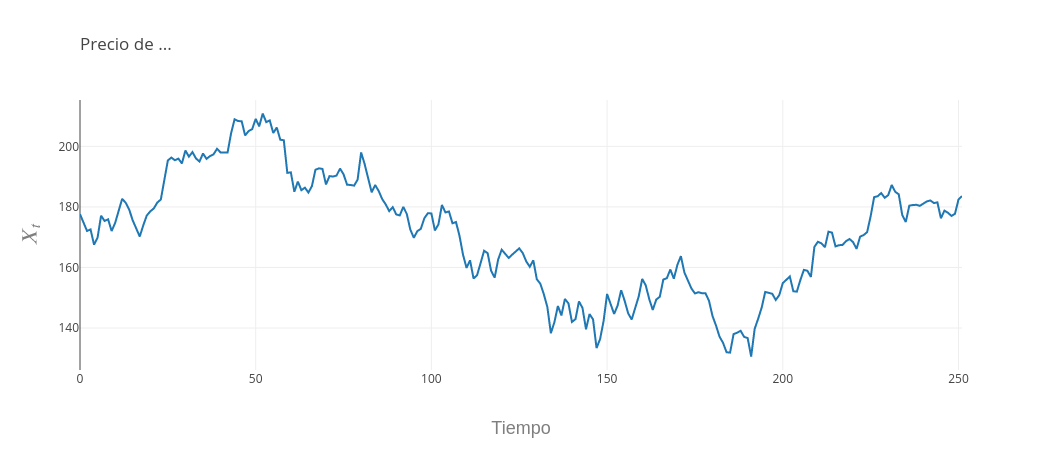

In [3]:
trace1 = go.Scatter(
    y = X,
    x = np.arange(N),
    name = '$X_1$'
)

data = [trace1]
layout = go.Layout(
    title=go.layout.Title(
        text='Precio de ...',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$X_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Accion')

**Gráfica de los retornos instantáneos**

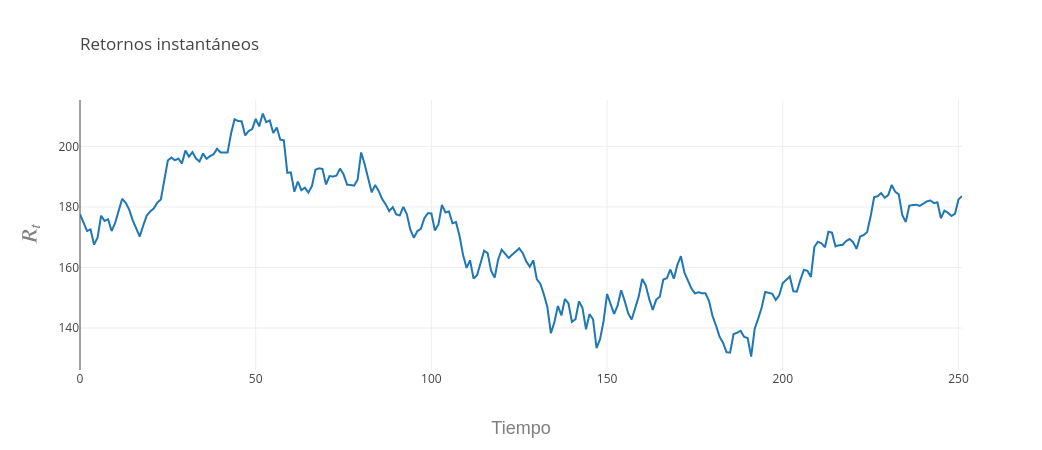

In [4]:
trace1 = go.Scatter(
    y = X,
    x = np.arange(N),
    name = '$R_t$'
)

data = [trace1]
layout = go.Layout(
    title=go.layout.Title(
        text='Retornos instantáneos',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$R_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Retornos')

**Test de normalidad**

In [5]:
jb = stats.jarque_bera(R)
lilie = lilliefors(R)
shapiro = stats.shapiro(R)

In [6]:
df = pd.DataFrame()
df['Jarque Bera'] = [jb[1]]
df['Shapiro Wilks'] = [shapiro[1]]
df['Lilliefors'] = [lilie[1]]

In [7]:
def hFD(a, k_max): 
# Higuchi FD
    L = []
    x = []
    N = len(a)

    for k in range(1,k_max):
        Lk = 0
        for m in range(0,k):
            #we pregenerate all idxs
            idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)
            Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
            Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
            Lk += Lmk

        L.append(np.log(Lk/(m+1)))
        x.append([np.log(1.0/ k), 1])

    (p, r1, r2, s)=np.linalg.lstsq(x, L)
    return p[0]

In [8]:
def hurst(signal):
    tau = []; lagvec = []

    #  Step through the different lags
    for lag in range(2,20):

    #  produce price difference with lag
        pp = np.subtract(signal[lag:],signal[:-lag])

    #  Write the different lags into a vector
        lagvec.append(lag)

    #  Calculate the variance of the difference vector
        tau.append(np.std(pp))

    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lagvec),np.log10(tau),1)

    # calculate hurst
    hurst = m[0]

    return hurst

In [9]:
df['Coeficiente de Hurst'] = hurst(X)
df['Dimensión Fractal'] = hFD(X, 8)

In [10]:
print(df.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 Jarque Bera &  Shapiro Wilks &  Lilliefors &  Coeficiente de Hurst &  Dimensión Fractal \\
\midrule
    0.194518 &       0.254392 &    0.006581 &               0.48055 &           1.555669 \\
\bottomrule
\end{tabular}



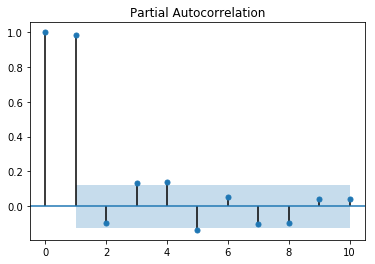

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(X,lags=10)
plt.show()

**Estimación de parámetros**

In [12]:
dt = 1/len(R)
media = np.mean(R)
varianza = np.var(R)
mu = media/dt
sigma = np.sqrt(varianza/dt)
print('$\mu: '+str(mu)+'$\n'+'$\sigma: '+str(sigma)+'$')

$\mu: 0.09179175783287559$
$\sigma: 0.34275669927046837$


In [13]:
from sklearn.metrics import mean_squared_error as mse
ms = []

In [17]:
# Parametros
dt = 1/252
#mu = 0.5
sg = sigma
# Condicion inicial
X0 = X[0]
k = 1000
S = np.zeros((k,N))
for i in range(k):
    S[i,0] = X0
for i in range(k):
    for j in range(1,N):
        S[i,j] = X[j-1] + mu*X[j-1]*dt + sg*X[j-1]*np.sqrt(dt)*np.random.normal()
    ms.append(mse(S[i,:],X))

In [18]:
print(np.mean(ms))

25.97142368462997


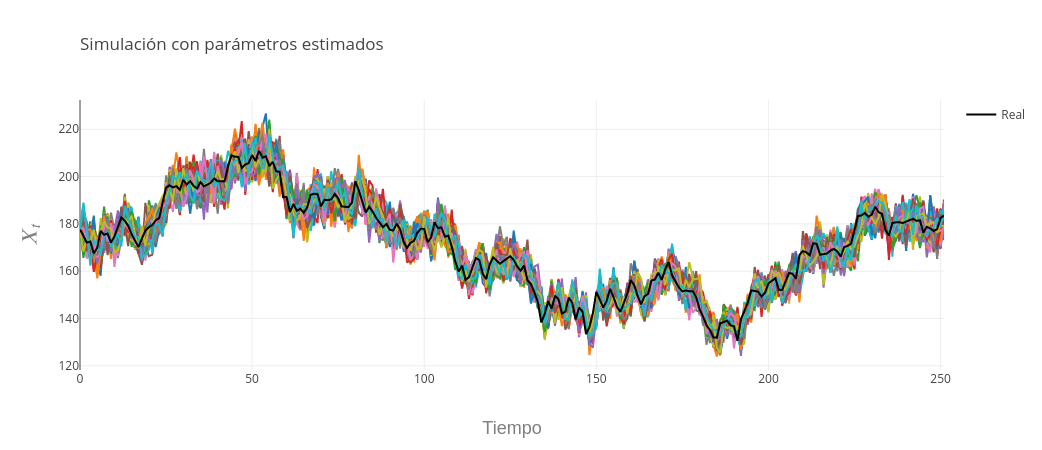

In [14]:
data=[]
for i in range(k):
    trace1 = go.Scatter(
        y = S[i],
        x = np.arange(N),
        showlegend=False
    )
    data.append(trace1)

trace2 = go.Scatter(
    y = X,
    x = np.arange(N),
    mode = 'lines',
    line = dict(color = 'rgb(0,0,0)'),
    name = 'Real'
)
data.append(trace2)
layout = go.Layout(
    title=go.layout.Title(
        text='Simulación con parámetros estimados',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$X_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Estimacion')

*Opciones*

In [40]:
# Parametros
# condicion inicial
S0 = X[-1]
# Tasa de interés libre de riesgo
r = 0.05
# Precio de ejercicio
K = 1.1*S0

In [42]:
op = pd.DataFrame()

In [43]:
def black(T):
    d1 = (np.log(S0/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    import scipy.stats as ss
    N = ss.norm(0,1)
    fcall = S0*N.cdf(d1) - K*np.exp(-r*T)*N.cdf(d2)
    return fcall    

In [44]:
# Simulación montecarlo
def montecarlo(T):
    k = 100
    M = 200
    N = 250
    dt = T/N
    S = np.zeros([k,N]) # Filas cada tracyectoria, columnas el tiempo
    payoff=np.zeros(k) #en cada simulacion saco el payoff de cada trayectoria
    opcion=np.zeros(M) #Tantas opciones como simulaciones
    for h in range(M):
        for i in range(k):
            S[i,0] = S0
        for i in range(k):
            for t in range(N-1):
                S[i,t+1]=S[i,t]+r*S[i,t]*dt+sigma*S[i,t]*np.sqrt(dt)*np.random.normal()
            payoff[i]=np.max([S[i,N-1]-K,0]) 
        opcion[h]=np.exp(-r*T)*np.mean(payoff); 
    opcionmedio = np.mean(opcion)
    opcionmax = np.max(opcion)
    opcionmin = np.min(opcion)
    return opcionmedio

In [45]:
# Árboles binomiales
def binomial(T):
    n = 50
    dt = T/n
    u = np.exp(sigma*np.sqrt(dt)) # Proporción de subida
    d = 1/u # Proporción de bajada
    p = (np.exp(r*dt)-d)/(u-d) # Probabilidad de salto
    f = np.zeros((n+1,n+1))
    for j in range(n+1):
        a = np.maximum(S0*(u**(n-j))*(d**(j)) - K,0)
        f[n,j] = a
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            f[i,j] = np.exp(-r*dt)*((1-p)*f[i+1,j+1] + (p)*f[i+1,j])
    return f[0,0]

In [46]:
# Diferen
def diferencias(T):
    S_max = 2*S0 
    dS = 0.2   
    M = int(np.ceil(S_max//dS))
    dT_tmp = (dS/(sigma*S_max))**2
    N_tmp = T/dT_tmp
    N = int(np.ceil(N_tmp))
    dT = T/N
    a = np.zeros(M+1)
    b = np.zeros(M+1)
    c = np.zeros(M+1)
    for j in range(M+1):
        a[j] = (dT/(1+r*dT)) * ((sigma**2 * j**2)/2 - (r * j/2))
        b[j] = (dT/(1+r*dT)) * ((1/dT) - sigma**2 * j**2)
        c[j] = (dT/(1+r*dT)) * ((sigma**2 * j**2)/2 + (r * j/2))
    # Crear Malla F
    F = np.zeros((N+1, M+1))

    # Condiciones de frontera
    F[:,0] = 0

    for j in range(M):
        F[N, j] = max(j*dS - K, 0)

    F[:, M] = S_max - K

    for i in reversed(range(N)):
        for j in reversed(range(1, M)):
            F[i,j] = a[j] * F[i+1, j-1] + b[j] * F[i+1, j] + c[j] * F[i+1, j+1]
    P = S0//dS;
    FF = F[0,int(P)]
    return FF

In [47]:
aa = [1/4, 1/2, 1, 1/6]
for t in aa:
    rrr = []
    rrr.append(black(t))
    rrr.append(montecarlo(t))
    rrr.append(binomial(t))
    rrr.append(diferencias(t))
    rrr = pd.Series(rrr)
    op[t] = rrr

0.25
0.5
1
0.16666666666666666


In [48]:
op.index = ['Black Scholes', 'Simulación Montecarlo', 'Árboles binomiales', 'Diferencias Finitas']

In [49]:
print(op.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  0.250000 &   0.500000 &   1.000000 &  0.166667 \\
\midrule
Black Scholes         &  6.646069 &  12.429880 &  21.527806 &  4.363487 \\
Simulación Montecarlo &  6.489752 &  12.251892 &  21.314724 &  4.379344 \\
Árboles binomiales    &  6.595822 &  12.499977 &  21.408831 &  4.395547 \\
Diferencias Finitas   &  6.577195 &  12.341069 &  21.332488 &  4.305624 \\
\bottomrule
\end{tabular}

